# Image Captioning

## Imports

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PLL import Image
from cache import cache

In [74]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load Data

In [77]:
import coco

In [78]:
# coco.set_data_dir("data/coco/")

In [79]:
coco.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.


In [80]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data loaded from cache-file: data/coco/records_train.pkl


In [81]:
num_images_train = len(filenames_train)
num_images_train

118287

In [82]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: data/coco/records_val.pkl


### Helper-Functions for Loading and Showing Images

This is a helper-function for loading and resizing an image.

In [83]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

## Tokenizer

In [99]:
mark_start = 'ssss '
mark_end = ' eeee'

This helper-function wraps all text-strings in the above markers. Note that the captions are a list of list, so we need a nested for-loop to process it. This can be done using so-called list-comprehension in Python.

In [100]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [157]:
captions_train_marked = mark_captions(captions_train)

In [103]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

In [104]:
captions_train_flat = flatten(captions_train_marked)

In [105]:
num_words = 10000

In [167]:
class TokenizerWrap(Tokenizer):
    def __init__(self, texts, num_words=None):
        Tokenizer.__init__(self, num_words=num_words)
        self.fit_on_texts(texts)
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))
    def token_to_word(self, token):
        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [107]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

Wall time: 8.75 s


In [168]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

In [169]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [170]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

Wall time: 10.9 s


### Steps Per Epoch

In [171]:
num_captions_train = [len(captions) for captions in captions_train]

This is the total number of captions in the training-set.

In [172]:
total_num_captions_train = np.sum(num_captions_train)

This is the approximate number of batches required per epoch, if we want to process each caption and image pair once per epoch.

In [173]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

1541

## Create the Recurrent Neural Network

In [174]:
state_size = 512

The embedding-layer converts integer-tokens into vectors of this length:

In [125]:
embedding_size = 128

In [126]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [127]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [128]:
decoder_input = Input(shape=(None, ), name='decoder_input')

In [129]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

In [130]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

In [131]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

### Connect and Create the Training Model

In [132]:
def connect_decoder(transfer_values):
    initial_state = decoder_transfer_map(transfer_values)
    # Start the decoder-network with its input-layer.
    net = decoder_input   
    # Connect the embedding-layer.
    net = decoder_embedding(net)    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)
    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)   
    return decoder_output

In [133]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [134]:
decoder_model.compile(optimizer=RMSprop(lr=1e-3),
                      loss='sparse_categorical_crossentropy')

### Compile the Model

In [135]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [136]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [137]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Train the Model

In [142]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=3,
                  callbacks=callbacks) 

   2/1541 [..............................] - ETA: 7:46:45 - loss: 0.8358WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (13.765023). Check your callbacks.


   4/1541 [..............................] - ETA: 5:22:10 - loss: 0.8711

KeyboardInterrupt: 

## Generate Captions

This function loads an image and generates a caption using the model we have trained.

In [175]:
def generate_caption(image_path, max_tokens=30):
    image = load_image(image_path, size=img_size)
    image_batch = np.expand_dims(image, axis=0)
    transfer_values = image_model_transfer.predict(image_batch)
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start
    output_text = ''
    count_tokens = 0
    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        decoder_output = decoder_model.predict(x_data)
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        sampled_word = tokenizer.token_to_word(token_int)
        output_text += " " + sampled_word
        count_tokens += 1
    output_tokens = decoder_input_data[0]
    plt.imshow(image)
    plt.show()
    print("Predicted caption:")
    print(output_text)
    print()

### Examples

Try this with a picture of a parrot.

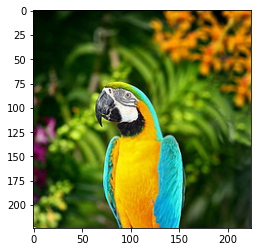

Predicted caption:
 a close up of a bird with a green beak eeee



In [176]:
generate_caption("images/parrot_cropped1.jpg")

Try it with a picture of a person (Elon Musk). In Tutorial #07 the Inception model mis-classified this picture as being either a sweatshirt or a cowboy boot.

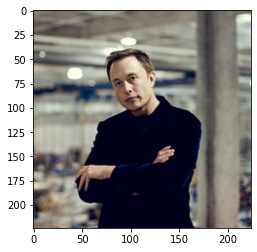

Predicted caption:
 a woman in a red top is holding a cellphone eeee



In [156]:
generate_caption("images/elon_musk.jpg")